# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot( history.history[metric_name] , color='blue', label=metric_name)
    plt.plot( history.history['val_' + metric_name] , color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [15]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)

df = df.sample(frac=1).reset_index(drop=True) # returns the same df but randomly shuffled


# Split the data into train and test with 80 train / 20 test

train, test = train_test_split(df , test_size=0.2) # returns df not nparray
train_stats = train.describe() # for normalization we work on the training set
print(type(train_stats))
print(train_stats)
#print(train_stats.loc[:,'X1']) #returns X1 column
#print(train_stats['X1']) #returns X1 column

# Get Y1 and Y2 as the 2 outputs and format them as np arrays

train_stats.pop('Y1') # removes Y1 and Y2 from stats
train_stats.pop('Y2')

train_stats = train_stats.transpose() # so that we can access the mean and std easy as they will be columns
#print(train_stats['count'])
print(train_stats)

train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

<class 'pandas.core.frame.DataFrame'>
               X1          X2          X3          X4          X5          X6  \
count  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000   
mean     0.762199  673.191368  318.659609  177.265879    5.227199    3.488599   
std      0.104695   87.445726   43.584673   45.040561    1.751278    1.117428   
min      0.620000  514.500000  245.000000  110.250000    3.500000    2.000000   
25%      0.660000  612.500000  294.000000  147.000000    3.500000    2.000000   
50%      0.740000  686.000000  318.500000  220.500000    3.500000    3.000000   
75%      0.820000  759.500000  343.000000  220.500000    7.000000    4.000000   
max      0.980000  808.500000  416.500000  220.500000    7.000000    5.000000   

               X7          X8          Y1          Y2  
count  614.000000  614.000000  614.000000  614.000000  
mean     0.231596    2.793160   22.080221   24.406498  
std      0.135061    1.590516   10.071045    9.460278  
min     

In [16]:
print(norm_train_X)

           X1        X2        X3        X4       X5        X6        X7  \
26  -0.689609  0.706823 -0.565786  0.959893 -0.98625 -1.332165  0.136264   
382  0.934154 -0.974220 -0.565786 -0.671969  1.01229 -0.437253  0.136264   
335  0.934154 -0.974220 -0.565786 -0.671969  1.01229  0.457659  0.136264   
50  -0.212032  0.146475 -1.690035  0.959893 -0.98625  0.457659 -0.974345   
184  0.552092 -0.694046 -0.003662 -0.671969  1.01229 -1.332165 -0.974345   
..        ...       ...       ...       ...      ...       ...       ...   
85  -1.167186  1.267170  0.558462  0.959893 -0.98625  0.457659 -0.974345   
183  2.080339 -1.814741 -0.565786 -1.487901  1.01229  0.457659 -0.974345   
395 -0.498578  0.426649 -1.127910  0.959893 -0.98625 -1.332165 -0.974345   
322  2.080339 -1.814741 -0.565786 -1.487901  1.01229 -1.332165  0.136264   
761  0.552092 -0.694046 -0.003662 -0.671969  1.01229 -1.332165  0.136264   

           X8  
26   1.387500  
382 -0.498681  
335  1.387500  
50  -1.127407  
184  0.

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [17]:
# Define model layers.
input_layer = Input( shape=( len(train .columns) , ) ) #A shape tuple (integers), not including the batch size.
                                                                                  #  For instance, `shape=(32,)` indicates that the expected input
                                                                                  #  will be batches of 32-dimensional vectors.

first_dense = Dense(units=128, activation='relu')(input_layer)
second_dense = Dense(units=128, activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units=1, name='y1_output')(second_dense)

third_dense = Dense(units=64, activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units=1, name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output] )

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [18]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)

model.compile(optimizer=optimizer, loss={'y1_output': 'mse' , 'y2_output': 'mse'}, # note that the key of dictionary is the name of out layer
                          metrics={ 'y1_output': tf.keras.metrics.RootMeanSquaredError() , 'y2_output': tf.keras.metrics.RootMeanSquaredError() } )

## Train the Model

In [19]:
# Train the model for 500 epochs
history = model.fit( norm_train_X , train_Y ,  epochs=500 , batch_size=10 , validation_data=(norm_test_X, test_Y) )

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 973us/sample - loss: 222.4544 - y1_output_loss: 107.7769 - y2_output_loss: 112.6907 - y1_output_root_mean_squared_error: 10.4314 - y2_output_root_mean_squared_error: 10.6602 - val_loss: 36.4156 - val_y1_output_loss: 14.7656 - val_y2_output_loss: 20.5127 - val_y1_output_root_mean_squared_error: 3.8999 - val_y2_output_root_mean_squared_error: 4.6050
Epoch 2/500
614/614 [==============================] - 0s 140us/sample - loss: 34.6973 - y1_output_loss: 13.1386 - y2_output_loss: 21.2730 - y1_output_root_mean_squared_error: 3.6414 - y2_output_root_mean_squared_error: 4.6300 - val_loss: 26.4953 - val_y1_output_loss: 10.7786 - val_y2_output_loss: 14.8992 - val_y1_output_root_mean_squared_error: 3.3390 - val_y2_output_root_mean_squared_error: 3.9174
Epoch 3/500
614/614 [==============================] - 0s 151us/sample - loss: 26.1169 - y1_output_loss: 10.4761 - y2_output_loss: 15.4378 - y1

## Evaluate the Model and Plot Metrics

In [20]:
# Test the model and print loss and mse for both outputs
# we evaluate model not history
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 194us/sample - loss: 2.2363 - y1_output_loss: 0.4155 - y2_output_loss: 1.8135 - y1_output_root_mean_squared_error: 0.6387 - y2_output_root_mean_squared_error: 1.3522
Loss = 2.236287113908049, Y1_loss = 0.41554659605026245, Y1_mse = 0.6386513113975525, Y2_loss = 1.8135077953338623, Y2_mse = 1.3521877527236938


In [21]:
# print( history.evaluate(x=norm_test_X, y=test_Y) )
# history only keeps info about the training and metrices

AttributeError: 'History' object has no attribute 'evaluate'

In [26]:
#history.history # dictionary
history.history.keys() # all the keys 


dict_keys(['loss', 'y1_output_loss', 'y2_output_loss', 'y1_output_root_mean_squared_error', 'y2_output_root_mean_squared_error', 'val_loss', 'val_y1_output_loss', 'val_y2_output_loss', 'val_y1_output_root_mean_squared_error', 'val_y2_output_root_mean_squared_error'])

In [28]:
len(history.history['loss']) # len == epochs

500

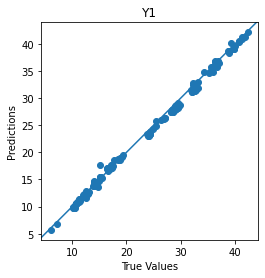

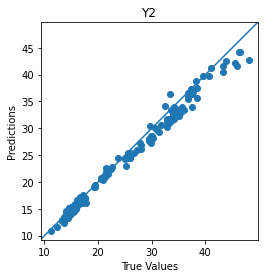

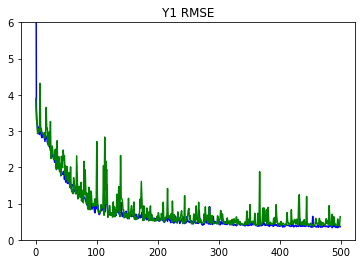

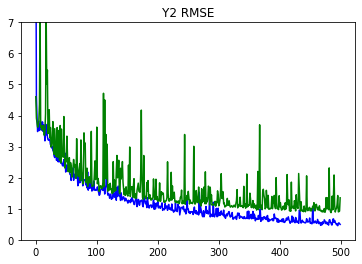

In [22]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)

plot_diff( test_Y[0], Y_pred[0], title='Y1')

plot_diff( test_Y[1], Y_pred[1], title='Y2')

plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)